# Preparing environment

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

import helpers as hlp
%aimport helpers
from data.preprocessing import save_file,load_file,get_scaled_series,encode
%aimport data.preprocessing

import settings


row_headers = settings.row_headers

#printing
pd.options.display.float_format = '{:,.2f}'.format

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Predict Quantities

## Load product cleaned features

In [5]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

2018-07-19 10:32:54,566 - __main__ - INFO - *** Build features for classification and prediction models ***
2018-07-19 10:32:54,566 - __main__ - INFO - Load raw sales file...
2018-07-19 10:32:54,571 - __main__ - INFO - Load product description file...
2018-07-19 10:32:54,911 - __main__ - INFO - Load clients count  file...
2018-07-19 10:32:54,938 - __main__ - INFO - Feature engineering...
2018-07-19 10:32:55,153 - __main__ - INFO - ==> Saving features file to clf_features ...
2018-07-19 10:32:55,207 - __main__ - INFO - Data set  6815  succefully made !
2018-07-19 10:32:55,207 - __main__ - INFO - Creating encoders...


### Other sales series files

In [7]:
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)
zclean_df,_ =  get_scaled_series(clean_df)


print("Sales: ",clean_df.shape)

#Load cleaned features for classification
filename ="clf_features"
df = load_file(filename,type_="P",index = "Product")
df.Ldate = df.Ldate.apply(lambda x:str(x))

numeric = (list(df.columns.to_series().groupby(df.dtypes).groups[np.dtype('float64')]))

#df.drop_duplicates(inplace=True)
print("Product Features:", df.shape)
df.head()
ohe = encode(df,non_categorical=numeric)
print("Encoded Features", ohe.shape)
df.head(5)

Sales:  (3529, 16)
Product Features: (6815, 11)
Encoded Features (6815, 160)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore
Product,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,0.13,Y,Autumn,0.01
30E000400_2,Black,Thick,45,4-6,Girls,One Internal Pants,Thick,0.11,$,Winter,0.39
30E823101_2,Grey,No Size,39,4-6,Girls,One Internal Pants,Thick,0.11,$,Winter,0.08
30E823102_2,Grey,No Size,39,7-9,Girls,One Internal Pants,Thick,0.11,$,Winter,0.08
30E823103_2,Grey,No Size,39,10-15,Girls,One Internal Pants,Thick,0.11,$,Winter,0.08


In [52]:
df.drop_duplicates().shape

(4949, 11)

### Missing Values

In [16]:
print(df[df.Nstore==0].shape)
df[df.Nstore==0].head()

(0, 11)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore
Product,,,,,,,,,,,


### Prepare training data

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score,mean_absolute_error

data = df.join(clean_df,how="inner")
features = df.columns

df  = df[df.Nstore != 0]

print(data.shape)

X_data = data[features]

series = data.drop(features,axis=1)
y_data = np.array([series.mean(axis=1), series.std(axis = 1)]).T
y_data = np.array(series.std(axis = 1)).T

#Keep the same X with features
# X =  pd.get_dummies(X_data)
X = encode(X_data,non_categorical = numeric)
y = y_data


print(X.shape,y.shape)
X.head()

(3481, 27)
(3481, 160) (3481,)


,Person_Boys,Person_Female,Person_Girls,Person_Men,Person_Pregnant,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,...,Ldate_50,Ldate_51,Ldate_52,Ldate_53,Ldate_6,Ldate_7,Ldate_8,Ldate_9,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.13,0.01
30E000400_2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.11,0.39
30E823101_2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.11,0.08
30E823102_2,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.11,0.08
30E823103_2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.11,0.08


### Train regressor

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
regr = RandomForestRegressor(n_estimators=100,max_depth =12 )


regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
yt_pred = regr.predict(X_train)

MU = "uniform_average"


def adjusted_r2(X,y,r_squared):
    return r_squared
#     return  1 - ((1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1))


# scores = cross_val_score(regr, X, y, cv=5, scoring='r2')
# print(scores)
# print(scores.mean(),np.median(scores))
print("Train")
rmse = math.sqrt(mean_squared_error(yt_pred,y_train,multioutput=MU))
print("RMSE: ",rmse)
r2 = r2_score(yt_pred,y_train,multioutput=MU)
print("R2: ",adjusted_r2(X_train,y_train,r2))
print("\nTest")
rmse = math.sqrt(mean_squared_error(y_pred,y_test,multioutput=MU))
print("RMSE: ",rmse)
r2 = r2_score(y_pred,y_test,multioutput=MU)
print("R2: ",adjusted_r2(X_test,y_test,r2))

Train
RMSE:  157.17357482228178
R2:  0.899842418324

Test
RMSE:  244.25509413692478
R2:  0.760024711055


### Save model

In [207]:
import pickle
from sklearn.externals import joblib
joblib.dump(regr,models_path+'regressor_std.pkl') 

['C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\notebooks\\7SEF\\..\\..\\models\\7SEF\\regressor_std.pkl']

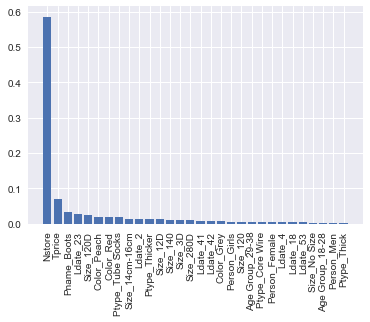

In [46]:
fi = regr.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), X.columns[imp],rotation = 90)
plt.show()